<a href="https://colab.research.google.com/github/HwayoungYoon/Data-Analysis-Practice/blob/master/bike-sharing-demand/kaggle_DS_bike_sharing_demand_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[부스트코스] 캐글 실습으로 배우는 데이터 사이언스**
## Ⅱ. 사이킷런으로 머신러닝 흐름 알기
https://www.edwith.org/boostcourse-ds-kaggle/lecture/57569
## Ⅲ. 랜덤포레스트로 자전거 수요량 회귀 예측하기
https://www.edwith.org/boostcourse-ds-kaggle/lecture/57570

---

학습기간 : 2020년 08월 01일 ~ 2020년 08월 05일

---

* 출처 : 박조은 강사님 [Github](https://github.com/corazzon/KaggleStruggle/tree/master/bike-sharing-demand) 

참고 URL
* [Bike Sharing Demand | Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data)
* [EDA & Ensemble Model (Top 10 Percentile) | Kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
* [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -1)](https://colab.research.google.com/drive/1aD1AWEshSX3VuCMvH2_emUuv7EKcc9eu#scrollTo=p1NASWPQe7rr&line=3&uniqifier=1)
* [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -2)](https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d)

# **1. Load Dataset**

**Description**

train 데이터를 이용해 test 데이터의 count 예측
* train.csv : 도시의 키오스크로 자전거를 대여한 기록에 대한 데이터셋
* test.csv : train.csv에서 casual, registered, count column을 제외한 데이터셋

**Data Fields**
* datetime(날짜) : hourly date + timestamp
* season(계절) : 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday(휴일) : whether the day is considered a holiday
* workingday(근무일) : whether the day is neither a weekend nor holiday
* weather(날씨)
  1. Clear, Few clouds, Partly cloudy, Partly cloudy
  2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp(온도) : temperature in Celsius
* atemp(체감온도) : "feels like" temperature in Celsius
* humidity(습도) : relative humidity
* windspeed(풍속) : wind speed
* casual(등록되지 않은 사용자) : number of non-registered user rentals initiated
* registered(등록된 사용자) : number of registered user rentals initiated
* count(총 대여수) : number of total rentals

**평가 방법**

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as 
![대체 텍스트](https://ifh.cc/g/msVaU1.png)

***
bike sharing demand는 지도 학습(supervised learning)과 비지도 학습(unsupervised learning) 중 지도 학습, 분류(classification)와 회귀(regression) 중 회귀와 관련된 문제
 
- 자전거 대여량을 예측하는 문제이기 때문
- 특정한 상황에 대한 count값이 있기 때문

In [ ]:
# Google Drive와 Colab 연동
# 실행 후 나오는 URL 접속하여 authorization code 받기
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd gdrive/My Drive/bike-sharing-demand/data

/content/gdrive/My Drive/bike-sharing-demand/data


In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# train 데이터를 가져온 후 행, 열의 갯수 확인
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [ ]:
# test 데이터를 가져온 후 행, 열의 갯수 확인
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

# **2. Feature Engineering**

In [ ]:
# train 데이터에서 datetime column을 분할하여 year, month, day, hour, minute, second, dayofweek column 생성
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [ ]:
# test 데이터에서 datetime column을 분할하여 year, month, day, hour, minute, second, dayofweek column 생성
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

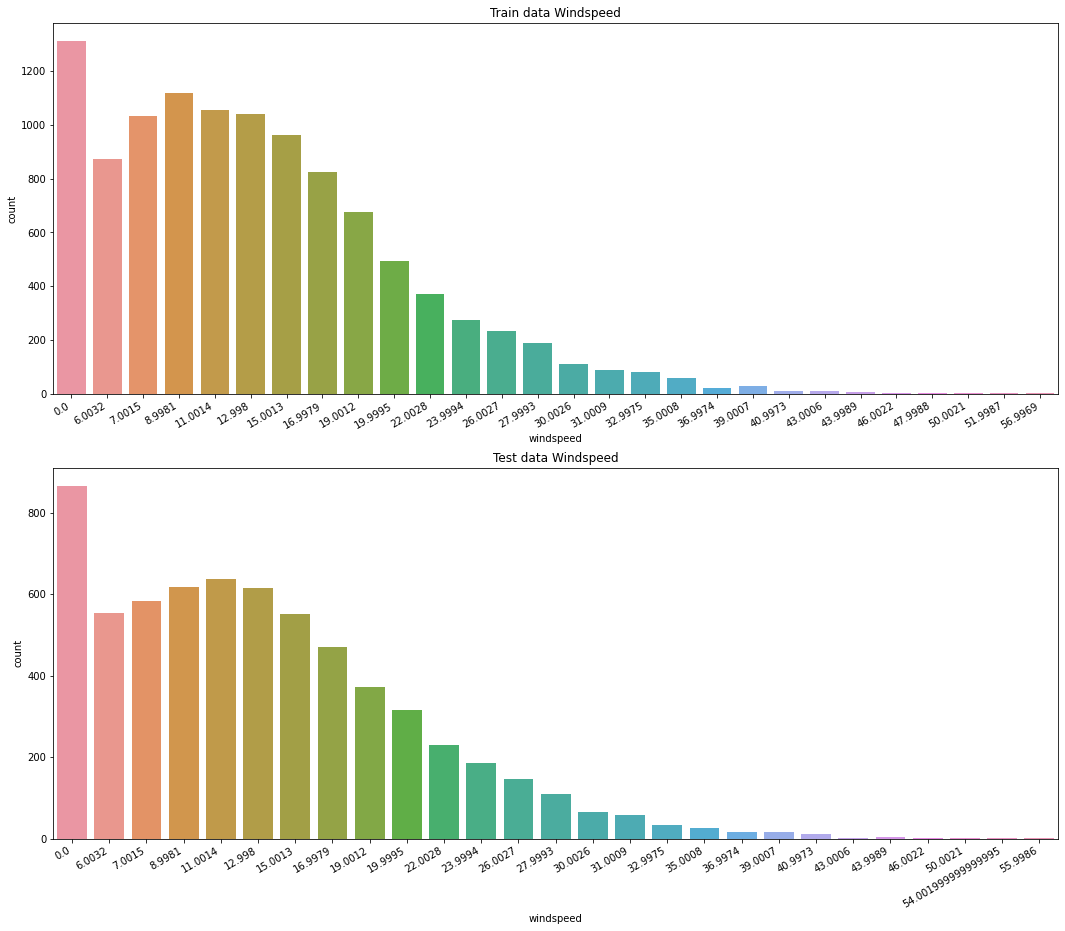

In [ ]:
# windspeed(풍속) 시각화
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,15)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="Train data Windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="Test data Windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

* widspeed(풍속)에 0값이 가장 많으므로 측정되지 않은 데이터를 0으로 기록했다고 볼 수 있다. 따라서 잘못 기록된 데이터를 고쳐 줄 필요가 있으므로 풍속의 0값에 특정한 값을 넣어준다.
* 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.

```
train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
```

In [ ]:
# 풍속이 0인것과 아닌 것의 세트 나눔
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [ ]:
# 머신러닝으로 예측하여 값이 0인 풍속 데이터 교체
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    ## 풍속이 0인 것(test data)과 아닌 것(train data)을 나눔
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    ## 풍속을 예측할 피처 선택
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    ## 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿈
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    ## 랜덤포레스트 분류기 사용
    rfModel_wind = RandomForestClassifier()

    ## wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킴
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    ## 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    ## 전체 예측 후 비교를 위해 예측한 값을 넣을 데이터 프레임을 새로 만듦
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    ## 값이 0으로 기록 된 풍속에 예측한 값을 넣음
    predictWind0["windspeed"] = wind0Values

    ## 0이 아닌 풍속이 있는 데이터프레임(dataWindNot0)과 예측한 값이 있는 데이터프레임(predictWind0) 병합
    data = predictWindNot0.append(predictWind0)

    ## 풍속의 데이터타입을 float으로 지정
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [ ]:
# 풍속의 0값을 조정
## train data와 test data 나눠서 조정
## 합쳐서 조정한 결과보다 train data만 조정한 결과의 score가 더 높게 나옴
train = predict_windspeed(train)
# test = predict_windspeed(test)

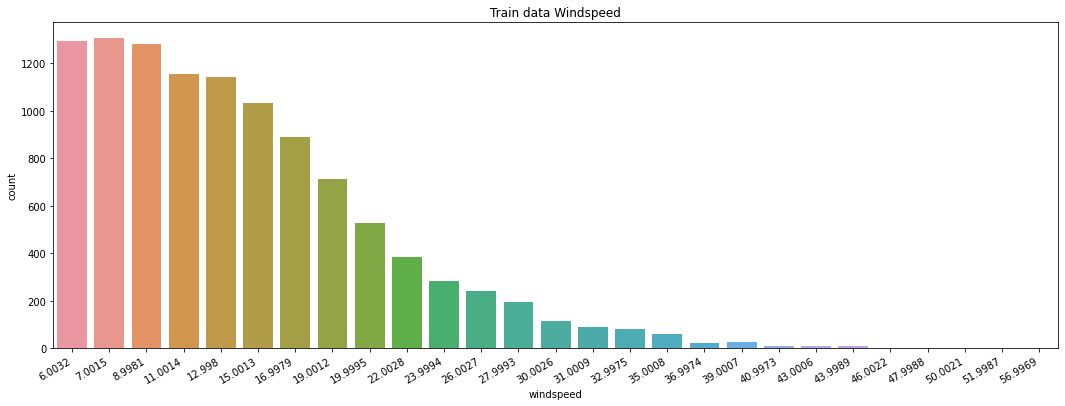

In [ ]:
# widspeed(풍속)의 0값을 조정한 데이터 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="Train data Windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

* 기존 train data에서의 0값이 사라진 것을 볼 수 있다.

# **3. Feature Selection**

* 신호와 소음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다. -> overfitting의 위험성
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.
* feature 분류
 * 연속형 : temp, humidity, windspeed, atemp
 * 범주형 : season, holiday, workingday, weather, dayofweek, month, year, hour

In [ ]:
# 범주형 feature의 type을 category로 변경
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [ ]:
# 피처 선택
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [ ]:
# train data에서 선택한 피처로 새로운 데이터셋 X_train 행렬 생성
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [ ]:
# test data에서 선택한 피처로 새로운 데이터셋 X_test 행렬 생성
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [ ]:
# count를 label로 설정
label_name = "count"

# train data에서 새로운 데이터셋 y_train 벡터 생성
y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# **4. Score**

### **평가 방법 : RMSLE**

* 과대평가된 항목보다는 과소평가된 항목에 패널티를 준다.
* 오차(Error) 제곱(Square)의 평균(Mean) 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다. 따라서 0에 가까운 값이 나올수록 정밀도가 높다.
* Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$ \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log( p_i + 1) - \log(a_i + 1))^2} } $
$ = \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log \frac {p_i + 1} {a_i + 1} )^2} } $
* 
 * n : the number of hours in the test set
 * p_i : your predicted count
 * a_i : the actual count
 * log(x) : the natural logarithm

* 잔차(residual)에 대한 평균에 로그를 씌운 값이다.
* 과대평가된 항목보다 과소평가된 항목에 패널티를 주기 위해 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미다.
* 값이 작을수록 오류가 적음을 의미한다.

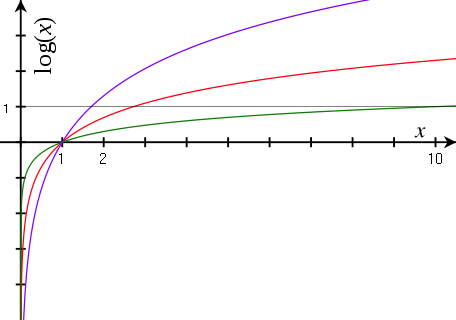

* 이미지 출처 : 위키피디아 https://ko.wikipedia.org/wiki/로그
* 더 자세한 설명은 [RMSLE cost function](https://www.slideshare.net/KhorSoonHin/rmsle-cost-function) 참고

In [ ]:
# RMSLE 공식 계산
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    ## 넘파이를 이용해 배열 형태로 변경
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    ## 예측값과 실제값에 1을 더하고 로그를 씌움
    ## 0일 때 마이너스 무한대가 되기 때문에 1을 더해주고 로그를 씌움
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    ## 위에서 계산한 예측값에서 실제값을 빼서 제곱
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균 계산
    mean_difference = difference.mean()
    
    # 루트 씌움
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## **Cross Validation 교차 검증**

* 일반화 성능을 측정하기 위해 데이터를 여러번 반복해서 나누고 여러 모델을 학습한다.
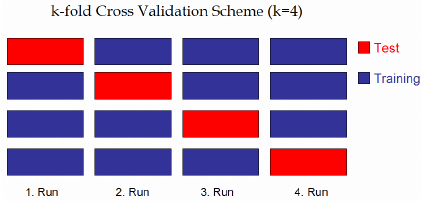

* KFold 교차검증
  * 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
  * 첫번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련 세트로 사용하여 학습한다.
  * 나머지 훈련 세트로 만들어진 세트의 정확도를 첫번째 폴드로 평가한다.
  * 다음은 두번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련 세트를 두번째 폴드로 정확도를 측정한다.
  * 이 과정을 마지막 폴드까지 반복한다.
  * 이렇게 훈련 세트와 테스트 세트로 나누는 N개의 분할마다 정확도를 측정하여 평균값을 낸 것이 정확도가 된다.

* 이미지 출처 : https://www.researchgate.net/figure/228403467_fig2_Figure-4-k-fold-cross-validation-scheme-example

In [ ]:
# KFold 교차검증
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# **5. RandomForest**

In [ ]:
# RandomForest로 예측
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

* n_estimators 값이 높을수록 좋은 성능을 내지만 시간이 오래 걸린다.

In [ ]:
# score 계산(time으로 찍어봄)
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 4.03 s, sys: 860 ms, total: 4.89 s
Wall time: 32.3 s
Score= 0.33116


## **1) Train**

In [ ]:
# 피팅 : 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.65,   5.04,   4.03,   3.57,   3.22,   6.18,  38.38, 105.08,
       236.3 , 137.64])

[Text(0.5, 1.0, 'test')]

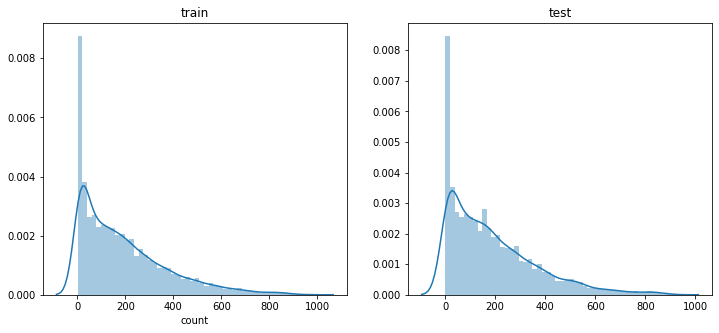

In [ ]:
# 예측한 count 값에 대한 시각화
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

* train 데이터셋을 바탕으로 학습하여 예측을 진행했다.
* test data의 count 예측값은 train data와 마찬가지로 0값이 많은 것으로 보여진다.
* train data와 test data의 형태가 완벽하게 일치하지는 않지만 비슷함을 볼 수 있다.

## **2) Submit**

In [ ]:
# sampleSubmission 데이터 가져오기
submission = pd.read_csv("sampleSubmission.csv")
submission

# submission 데이터의 count 값에 예측한 값 넣기
submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.65
1,2011-01-20 01:00:00,5.04
2,2011-01-20 02:00:00,4.03
3,2011-01-20 03:00:00,3.57
4,2011-01-20 04:00:00,3.22


In [ ]:
# score 값을 넣은 submission 파일 생성
submission.to_csv("Score_{0:.5f}_submission.csv".format(score), index=False)